# **DIVE INTO CODE COURSE**
## **Sprint Deep Learning - Neural Network**
**Student Name**: Doan Anh Tien<br>
**Student ID**: 1852789<br>
**Email**: tien.doan.g0pr0@hcmut.edu.vn

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import random
from math import log2

**Dataset Preparation**

In [5]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
print(X_train.shape) # (60000, 28, 28)
print(y_train.shape) # (10000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(y_train.shape)
print(X_train[0].dtype) # uint8

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(60000,)
uint8


**Smoothing**

In [7]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

**Visualization**

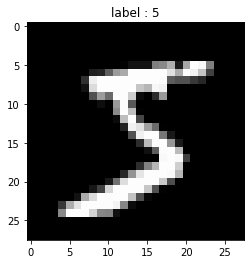

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

**Preprocessing**

In [9]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [10]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print("Original label: {}".format(y_train.shape)) # (60000,)
print("One hot train label: {}".format(y_train_one_hot.shape)) # (60000, 10)
print("One hot test label: {}".format(y_test_one_hot.shape))

Original label: (60000,)
One hot train label: (60000, 10)
One hot test label: (10000, 10)


In [65]:
def one_hot(y):
    C = np.unique(y).size
    y_hot = np.eye(C)[:,y.reshape(-1)]
    
    return y_hot

In [11]:
X_train = X_train.T
X_test = X_test.T
y_train_one_hot = y_train_one_hot.T
y_test_one_hot = y_test_one_hot.T

In [12]:
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_test.shape) # (12000, 784)
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)

(784, 60000)
(784, 10000)
(10, 60000)
(10, 10000)


### **[Problem 1 2 3 4] Initialize Weight, Forward Propagation, Cross Entropy Error, Backward Propagation**

In [13]:
def GetMiniBatch(X, Y, batch_size):
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    mini_batches = []
    m = X.shape[1]
    # Shuffle
    permute = np.random.permutation(m)
    X = X[:,permute]
    Y = Y[:,permute]
    
    # Partition
    complete_batches = math.floor(m/batch_size)
    for k in range(complete_batches):
        batch_X = X[:,k*batch_size:(k+1)*batch_size]
        batch_Y = Y[:,k*batch_size:(k+1)*batch_size]
        batch = (batch_X,batch_Y)
        mini_batches.append(batch)
        
    # Handling the end case
    if m % batch_size != 0:
        batch_X = X[:,(k+1)*batch_size:]
        batch_Y = Y[:,(k+1)*batch_size:]
        batch = (batch_X,batch_Y)
        mini_batches.append(batch)
        
    return mini_batches

**Initialize Weight**

Despite the assignment indicates the number of layer is 3, I manage to modify the weight initialization into flexible module, in which it can assign the weight and bias in any layer structure we want. Thus, after completing the neural network class, I can evaluate in any different settings and compare the results between models.

In [14]:
layers = [10, 5, 3, 1]
n_features = 5
sigma = 0.01
params = {}

for l in range(1, len(layers)):

    params['W' + str(l)] = sigma * np.random.randn(layers[l], layers[l-1])
    params['b' + str(l)] = sigma * np.random.randn(layers[l],1)

params

{'W1': array([[ 0.00409095,  0.01309129,  0.00585426, -0.00796825,  0.00490966,
          0.00133242,  0.00266017,  0.00727734, -0.00024916,  0.01850379],
        [-0.00161329,  0.00946845,  0.00284274,  0.00047777, -0.00462652,
          0.0029055 ,  0.00735114,  0.0050938 ,  0.01398608, -0.01129118],
        [ 0.00937088,  0.00222923, -0.01025773,  0.00738951, -0.0053502 ,
          0.01391147, -0.0002065 , -0.00019165, -0.00731662,  0.00153386],
        [ 0.00700247,  0.00016431,  0.0013886 , -0.00897435,  0.01034144,
          0.00945859,  0.00083892, -0.00564102, -0.00496349, -0.00479131],
        [-0.00158428,  0.02135585, -0.00739301, -0.00745498, -0.00721221,
          0.00083145,  0.00815745,  0.00395649, -0.00424363,  0.00452243]]),
 'W2': array([[-0.00245922,  0.00991892,  0.00934048, -0.00795829, -0.00033974],
        [-0.0270337 ,  0.02030902,  0.00712583, -0.00318083,  0.01014419],
        [ 0.00188335, -0.00305992, -0.00287578, -0.01202676,  0.00526596]]),
 'W3': array([

In [104]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    Simple three-layer neural network classifier
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, layers, lr=0.001, sigma=0.01, batch_size=20, epochs=5, verbose=True):

        self.layers = layers
        self.lr = lr
        self.sigma = sigma
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose

        self.param = {}
        self.loss = []
        self.n_features = None
        self.X_train = None
        self.y_train = None


    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """

        param = self.init_weight()
        self.iter = np.ceil(X.shape[1]//self.batch_size)

        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
        print("Batch size: {}".format(self.batch_size)) 
        print("Iteration: {}".format(self.iter))

        for i in range(self.epochs):
            epoch_cost = 0

            for mini_batch in get_mini_batch:
                # Forward propagation
                (mini_X_train, mini_y_train) = mini_batch

                A_last, stored_var = self.forward_propagation(mini_X_train, param)

                # Cross entropy error
                cost = self.cross_entropy_loss(mini_y_train, A_last)
                epoch_cost += cost

                # Backward propagation
                grads = self.backward_propagation(A_last, mini_y_train, stored_var, param)

                param = self.update_parameters(param, grads)
            
            self.loss.append(epoch_cost/self.iter)
            if self.verbose:
                print("Cost after epoch {}: {}".format(i, epoch_cost/self.iter))
        
        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Cost (per epoch)')
        plt.xlabel('Epochs')
        plt.title("Learning rate =" + str(self.lr))
        plt.show()

        self.param = param

        return param
    
    def init_weight(self):
        """
        Initialize the weight and bias of neural network
        """
        np.random.seed(42)
        L = len(self.layers)

        param = {}

        for l in range(L-1):
            param['W' + str(l+1)] = self.sigma * np.random.randn(self.layers[l+1], self.layers[l])
            param['b' + str(l+1)] = self.sigma * np.random.randn(self.layers[l+1], 1)

        return param


    def predict(self, X, param):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        probas, _ = self.forward_propagation(X, param)
        pred = np.argmax(probas,axis=0)

        return pred

    def accuracy(self, X, y, X_test, y_test, param):
        """
        Evaluate the accuracy of the neural network
        """
        pred_y = self.predict(X, param)
        train_acc = np.mean(pred_y.flatten() == y.flatten()) * 100
        print('Training set accuracy: {}%'.format(round(train_acc, 2)))

        pred_ytest = self.predict(X_test, param)
        test_acc = np.mean(pred_ytest.flatten() == y_test.flatten()) * 100
        print('Testing set accuracy: {}%'.format(round(test_acc, 2)))
        

    def sigmoid_function(self, A):
        
        return 1/(1+np.exp(-A))

    def tanh_function(self, A):
    
        return (np.exp(A)-np.exp(-A))/(np.exp(A)+np.exp(-A))

    def softmax_function(self, A):

        return np.exp(A)/(np.sum(np.exp(A), axis = 0))


    def activation_function_forward(self, A, activation):
        """
        Use the activation function for forward propagation process and also 
        return the raw output that does not goes through the activation function
        """
        y = None
        if activation == 'sigmoid':
            Z = self.sigmoid_function(A)

        if activation == 'tanh':
            Z = self.tanh_function(A)

        if activation == 'softmax':
            Z = self.softmax_function(A)

        return Z


    def forward_function(self, X, W, b):
        """
        The function involving the multiplication of features, weights and bias
        Then it uses the activation function to get the output value, and also
        return a set of variables to reuse in the backward propagation
        """
        A = np.dot(W, X) + b

        return A

    def forward_propagation(self, X, param):
        """
        The forward propagation process of neural network
        
        Note: Instead of creating a fixed size forward propagation,
        I manage to modify this function to fit any input of layers
        and the intial weights and bias

        (E.g: If I change to 5 layers, the model still run properly)
        """

        Z = X
        stored_var = {}
        stored_var['Z' + str(0)] = X
        L = len(param) // 2 # Because it contains both weight and bias, we divide by 2 to get length of pairs
        
        for l in range(1, L):
            # Use the previous output for the current function
            Z_prev = Z
            A = self.forward_function(Z_prev, param['W' + str(l)], param['b' + str(l)])
            stored_var['A' + str(l)] = A
            Z = self.activation_function_forward(A, activation='tanh')
            stored_var['Z' + str(l)] = Z

        # Last layer function
        A = self.forward_function(Z, param['W' + str(L)], param['b' + str(L)])
        stored_var['A' + str(L)] = A
        Z_last = self.activation_function_forward(A, activation='softmax')

        return Z_last, stored_var


    def activation_function_backward(self, A, activation):
        """
        Use the activation function for backward propagation process
        """
        act = None

        if activation == 'sigmoid':
            s = self.sigmoid_function(A)
            act = s * (1-s)

        if activation == 'tanh':
            s = self.tanh_function(A)
            act = (1 - s**2)

        return act

    def compute_grads(self, dA, grads, param, stored_var, l, m):
        
        # Derivative of weight and bias by using gradient of function A = W.X + b
        # The formula also consist of the variables that will be used in backwardpropagation,
        # therefore we need to get save and update them in the dictionary called grads
        dW = (1/m) * np.dot(dA, stored_var['Z' + str(l-1)].T)
        grads['dW' + str(l)] = dW

        db = (1/m) * np.sum(dA, axis=1, keepdims = True)
        grads['db' + str(l)] = db
        
        dZ_prev = np.dot(param['W' + str(l)].T, dA)
        grads['dZ'+ str(l-1)] = dZ_prev

        return grads

    
    def backward_propagation(self, Z_last, Y, stored_var, param):
        """
        The backward propagation process of neural network
        
        Note: Instead of creating a fixed size backward propagation,
        I manage to modify this function to fit any input of layers
        and the intial weights and bias

        (E.g: If I change to 5 layers, the model still run properly)
        """
        grads = {}

        L = len(param) // 2
        m = Z_last.shape[1]
        dA = (Z_last - Y)


        grads = self.compute_grads(dA, grads, param, stored_var, L, m)
        
        for l in reversed(range(1, L)):
            # Use the previous output for the current function
            dZ = grads['dZ' + str(l)]
            dA = dZ * self.activation_function_backward(stored_var['A' + str(l)], activation='tanh')
            
            grads = self.compute_grads(dA, grads, param, stored_var, l, m)

        del grads['dZ0']

        return grads


    def update_parameters(self, param, grads):
        """
        Update the parameter using gradient descent
        """
        L = len(param) // 2

        for l in range(L):
            param["W" + str(l+1)] = param["W" + str(l+1)] - self.lr * grads["dW" + str(l+1)]
            param["b" + str(l+1)] = param["b" + str(l+1)] - self.lr * grads["db" + str(l+1)]

        return param


    def cross_entropy_loss(self, Y, Z_last):
        """
        The object function of the neural network
        """
        m = Y.shape[0]

        # Avoid getting infinity at logarithm function by adding 1e-7
        return (1/m) * np.mean(-np.sum(Y*np.log(Z_last),axis=0))


### **[Problem 6 7] Learning and Estimation, Learning Curve Plot**

In [94]:
layers = [X_train.shape[0], 400, 200, 10]
lr = 0.001
sigma = 0.01
batch = 20
epochs = 3

nn = ScratchSimpleNeuralNetrowkClassifier(layers, lr=lr, sigma=sigma, batch_size=batch, epochs=epochs, verbose=True)

Batch size: 20
Iterration: 3000.0
Cost after epoch 0: 0.2297737807015607


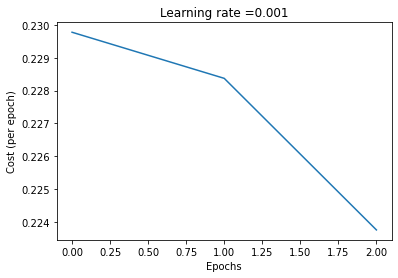

In [95]:
param = nn.fit(X_train, y_train_one_hot)

In [96]:
pred_y = nn.predict(X_test, param)
pred_y

array([7, 0, 1, ..., 7, 1, 0])

In [97]:
nn.accuracy(X_train, y_train, X_test, y_test, param)

Training set accuracy: 44.44%
Testing set accuracy: 44.56%


**Greater Epochs**

In [98]:
layers = [X_train.shape[0], 400, 200, 10]
lr = 0.001
sigma = 0.01
batch = 50
epochs = 10

nn2 = ScratchSimpleNeuralNetrowkClassifier(layers, lr=lr, sigma=sigma, batch_size=batch, epochs=epochs, verbose=True)

Batch size: 50
Iterration: 1200.0
Cost after epoch 0: 0.23006013937444222


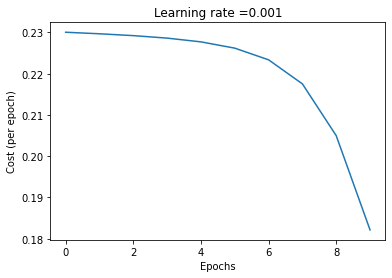

In [99]:
param2 = nn2.fit(X_train, y_train_one_hot)

In [101]:
nn2.accuracy(X_train, y_train, X_test, y_test, param2)

Training set accuracy: 48.21%
Testing set accuracy: 47.97%


**Greater Epochs and Increase in Learning Rate**

In [105]:
layers = [X_train.shape[0], 400, 200, 10]
lr = 0.01
sigma = 0.01
batch = 256
epochs = 100

nn3 = ScratchSimpleNeuralNetrowkClassifier(layers, lr=lr, sigma=sigma, batch_size=batch, epochs=epochs, verbose=True)

Batch size: 256
Iteration: 234.0
Cost after epoch 0: 0.2308656355838094
Cost after epoch 1: 0.22995862731045766
Cost after epoch 2: 0.22811157532768492
Cost after epoch 3: 0.22233271818036474
Cost after epoch 4: 0.19874528574291378
Cost after epoch 5: 0.15090870588070315
Cost after epoch 6: 0.1150816401623849
Cost after epoch 7: 0.09347830720539807
Cost after epoch 8: 0.08024566445352893
Cost after epoch 9: 0.07171029617995224
Cost after epoch 10: 0.06560206305483862
Cost after epoch 11: 0.06086119849283044
Cost after epoch 12: 0.05697358429237612
Cost after epoch 13: 0.05368376447546268
Cost after epoch 14: 0.05087502247338363
Cost after epoch 15: 0.04849064124252501
Cost after epoch 16: 0.04648272754042686
Cost after epoch 17: 0.044794633408035495
Cost after epoch 18: 0.043365877315105585
Cost after epoch 19: 0.04214175896197755
Cost after epoch 20: 0.041078276905969165
Cost after epoch 21: 0.04014217524115905
Cost after epoch 22: 0.039308838013337094
Cost after epoch 23: 0.038559919

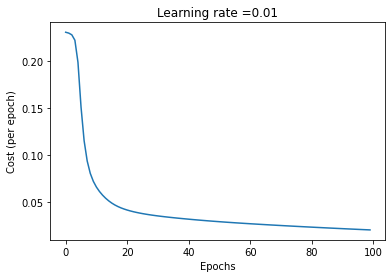

In [106]:
param3 = nn3.fit(X_train, y_train_one_hot)

In [107]:
nn3.accuracy(X_train, y_train, X_test, y_test, param3)

Training set accuracy: 94.34%
Testing set accuracy: 94.27%


### **[Problem 8] (Advance assignment) Confirmation of misclassification**

In [108]:
pred_y3 = nn3.predict(X_test, param3)
pred_y3

array([7, 2, 1, ..., 4, 5, 6])

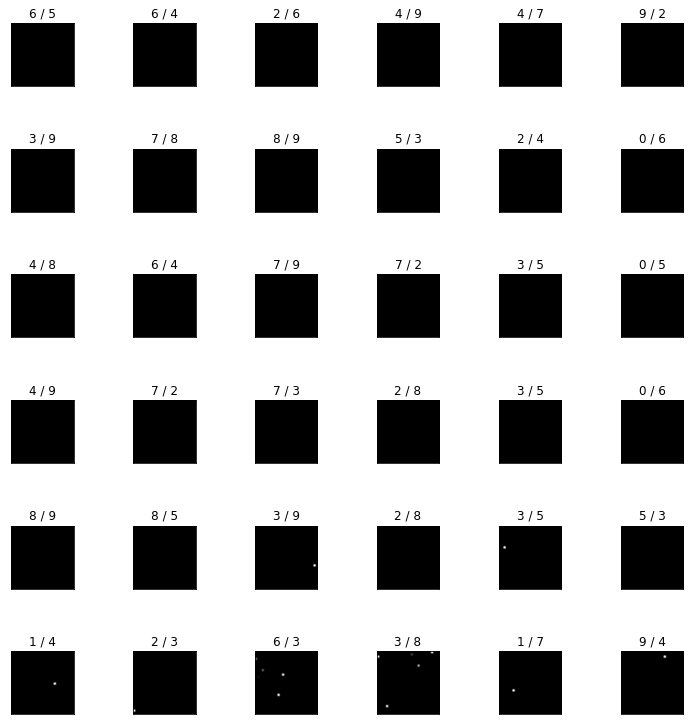

In [112]:
"""
Display word classification results side by side. The display above the image is "estimated result / correct answer".
Parameters:
----------
y_pred : Estimated ndarray (n_samples,)
y_val : Correct label of verification data (n_samples,)
X_val : Verification data features (n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # How many to display
X_val = X_test
true_false = pred_y3==y_test
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(pred_y3[false_list[i]],y_test[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')